# HEASARC Weekly Photon Dataset HATS Import

Path to Data: https://heasarc.gsfc.nasa.gov/FTP/fermi/data/lat/weekly/photon/

Notebook Creation Date: May 30, 2025

## Imports and Path setup


Use 0.5.0 versions of `hats-import` and `hats`, some issues currently with more recent versions (https://github.com/astronomy-commons/hats-import/issues/538):

In [ ]:
pip install hats-import==0.5.0 hats==0.5.0

In [1]:
# imports and paths
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
from hats_import.catalog.arguments import ImportArguments
from astropy.io import fits
from astropy.table import Table
import glob


# Set data paths
epyc_path = "/astro/store/epyc3/data3/hats/tmp/heasarc_photon/weekly/photon"  # path to input data
output_path = "/astro/store/epyc3/data3/hats/catalogs/heasarc_photon"  # path of output catalog
#single_fits = "lat_photon_weekly_w009_p305_v001.fits"

# Gather file lists for import
subset = glob.glob(epyc_path+"/lat_photon_weekly_w01*.fits")  # small subset for testing
full = glob.glob(epyc_path+"/lat_photon_weekly_*.fits")  # full weekly

/astro/users/brantd/.conda/envs/lsdb_latest/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A custom reader class is needed due to https://github.com/astronomy-commons/hats-import/pull/551, this issue has been resolved in latest hats, but is not available due to the version pins above:

In [2]:
import sys
import os

# Add the directory containing heasarc_reader.py to sys.path
heasarc_reader_path = "/astro/users/brantd/epyc/users/brantd/notebooks_lf/heasarc_import"  # heasarc_import.py in same directory
if heasarc_reader_path not in sys.path:
    sys.path.append(heasarc_reader_path)

from heasarc_reader import HeasarcReader

## hats-import setup and execution

In [ ]:
# Import arguments, using custom HeasarcReader

args = ImportArguments(
    sort_columns="EVENT_ID",
    ra_column="RA",
    dec_column="DEC",
    input_file_list=full,
    #file_reader="fits",  # use this when custom reader is no longer needed
    file_reader=HeasarcReader(),
    output_artifact_name="fermi_photon_catalog",
    output_path=f"{output_path}/heasarc_photon",
    dask_tmp="/astro/users/brantd/epyc/users/brantd/tmp/",  # setting a tmp directory in a known folder for dask is recommended when running on a distributed system
    #pixel_threshold=250,
)


In [ ]:
# Run the import pipeline
with Client(n_workers=15, threads_per_worker=1, memory_limit="20GB") as client:
    # with a single thread, the memory_limit here may be overly conservative, feel free to experiment with reducing it
    pipeline_with_client(args, client)

## Viewing the resulting hats catalog

,ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4,CALIB_VERSION,EVENT_CLASS,EVENT_TYPE
npartitions=3969,,,,,,,,,,,,,,,,,,,,,,,
"Order: 3, Pixel: 0",float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],double[pyarrow],int32[pyarrow],int32[pyarrow],int16[pyarrow],int16[pyarrow],double[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],float[pyarrow],list<element: int32>[pyarrow],list<element: bool>[pyarrow],list<element: bool>[pyarrow]
"Order: 3, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 766",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 3, Pixel: 767",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


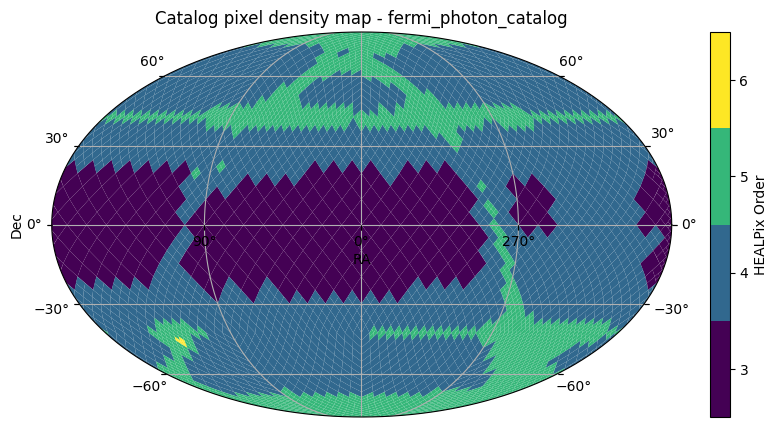

In [11]:
import lsdb

fermi_hats = lsdb.read_hats(f"{output_path}/heasarc_photon/fermi_photon_catalog")
fermi_hats.plot_pixels()
fermi_hats

In [10]:
fermi_hats.head(10)

,ENERGY,RA,DEC,L,B,THETA,PHI,ZENITH_ANGLE,EARTH_AZIMUTH_ANGLE,TIME,EVENT_ID,RUN_ID,RECON_VERSION,CONVERSION_TYPE,LIVETIME,DIFRSP0,DIFRSP1,DIFRSP2,DIFRSP3,DIFRSP4,CALIB_VERSION,EVENT_CLASS,EVENT_TYPE
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,
10541279145,266.246735,44.998108,0.010174,176.948715,-48.896721,40.149654,10.653901,117.142799,267.654297,384352167.108774,15790774,384346620,0,1,56.694139,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True False False True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False False False True False False False True False True False]
20217152121,258.676575,45.009258,0.014929,176.955276,-48.885391,40.136005,11.428685,113.861885,263.330566,416251227.972177,3256197,416250257,0,0,77.457941,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True False True True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False True False False False False True False False False True]
22748259158,1781.898682,45.018471,0.01793,176.9617,-48.876675,40.127544,11.930946,112.533775,266.534302,416474461.029987,11558044,416469061,0,0,226.069713,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True True True True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False False False False True True False False False False True]
23024570787,71.950012,45.020863,0.018986,176.963074,-48.874218,40.131554,18.987139,141.57251,286.135406,324626696.101382,1088591,324626226,0,1,43.645015,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True True True True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False False False True False False False False True True False]
35612897370,111.19416,44.99057,0.01286,176.937241,-48.900517,45.10215,289.144043,18.430609,133.681091,679235810.990807,1190845,679235320,0,0,182.013143,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True True True True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False False False False True False True False False False True]
39024795931,332.788452,44.99622,0.016144,176.940186,-48.89394,39.464252,205.071289,112.553444,263.802582,497252918.989879,8652298,497249502,0,0,13.362131,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True True True True True True True True True True True True],[False False False False False False False False False False False False False False False False False False False False False False False False True False False True False False False True]
66873955502,142.466873,44.998966,0.032329,176.925354,-48.88073,48.504581,205.077408,129.924973,292.391205,404033046.995197,3399768,404031352,0,1,104.261414,0.0,0.0,0.0,0.0,0.0,[0 0 0],[False False False False False False False True False False False False False False False True True False False False True True True True True True True True True True True True],[False False False False False False False False False False False False False False Fa